# Obesity and Socioeconomic Factors: Regression Analysis
### Intro
**Dataset:**

This dataset contains a number of different questions which determine the rate of obesity in different regions and take into account a number of socioeconomic factors such as age, education level, gender, income, race/ethnicity and location.

This dataset comes from the CDC and I am going via a Kaggle study to access it:
* https://www.kaggle.com/spittman1248/effect-of-socioeconomic-status-on-obesity

**Aim:**

To determine and quantify the effect of different socioeconomic factors on the rate/incidence of obesity.

### Initial Investigation of the Data
Let's begin by taking a look at the variables available to us.

In [53]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# show plots in notebook
%matplotlib inline

# read data
data = pd.read_csv('Obesity Data.csv')

# describe data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53392 entries, 0 to 53391
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   53392 non-null  int64  
 1   YearEnd                     53392 non-null  int64  
 2   LocationAbbr                53392 non-null  object 
 3   LocationDesc                53392 non-null  object 
 4   Datasource                  53392 non-null  object 
 5   Class                       53392 non-null  object 
 6   Topic                       53392 non-null  object 
 7   Question                    53392 non-null  object 
 8   Data_Value_Unit             0 non-null      float64
 9   Data_Value_Type             53392 non-null  object 
 10  Data_Value                  48346 non-null  float64
 11  Data_Value_Alt              48346 non-null  float64
 12  Data_Value_Footnote_Symbol  5046 non-null   object 
 13  Data_Value_Footnote         504

We can immediately discard a few of our variables which either contain no information (all blanks), contain redundant information (already present in other variables) or simply tell us nothing useful about the data.

We also want to extract only the relevant survey question, which is the % of adults who are obese.

In [54]:
# drop extraneous data
data = data.drop(['Total', 'Data_Value_Unit', 'Data_Value_Alt', 'YearEnd', 'Datasource'
                  'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit '], 1)

# select relevant question only
data = data[data['Question'] == 'Percent of adults aged 18 years and older who have obesity']

# examine survey types
data['StratificationCategoryId1'].value_counts()

KeyError: "['DatasourceData_Value_Footnote'] not found in axis"

The 'StratificationCategoryId1' variable tells us which rows correspond to which survey type. For example, 'RACE' refers to rows containing information in 'Race/Ethnicity' field whilst 'AGEYR' defines rows that have populated the 'Age (years)' field.

We will use this field to subdivide out dataset for differential analysis.

In [ ]:
# subdivide dataset based on survey type
race = data[data['StratificationCategoryId1'] == 'RACE']
income = data[data['StratificationCategoryId1'] == 'INC']
age = data[data['StratificationCategoryId1'] == 'AGEYR']
education = data[data['StratificationCategoryId1'] == 'EDU']
gender = data[data['StratificationCategoryId1'] == 'GEN']
overall = data[data['StratificationCategoryId1'] == 'OVR']

### Gender
Before diving in, let's have a quick look at the most and least obese states (vs. national average) to see if there are any outliers or anything else that might need attention.

In [107]:
# extract relevant columns for analysis
gender_sub = gender[['LocationAbbr', 'LocationDesc', 'Gender', 'Data_Value']
gender_sub.head()

,LocationAbbr,LocationDesc,Gender,Data_Value
1,AL,Alabama,Male,32.3
2,AL,Alabama,Female,31.8
179,US,National,Female,27.4
255,AL,Alabama,Male,31.8
256,AL,Alabama,Female,34.1


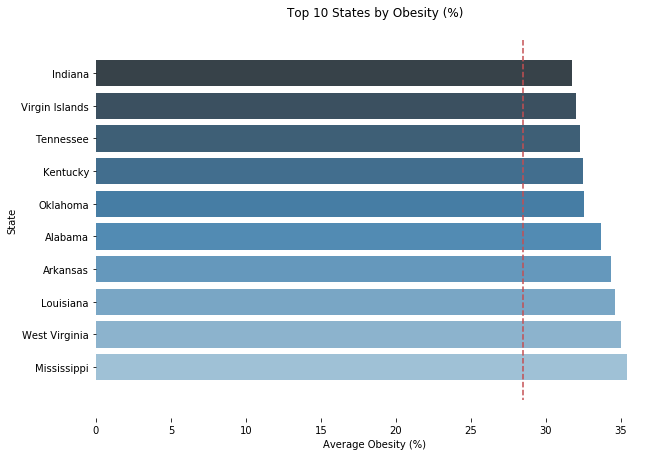

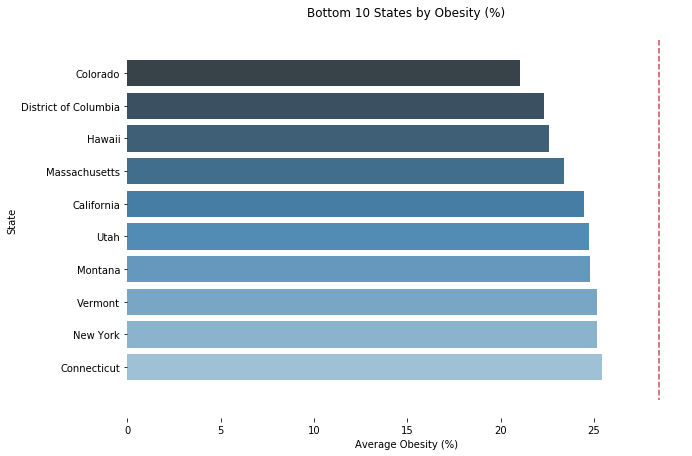

In [140]:
# calculate mean obesity level across the nation for comparison with each state
mean_obesity = gender_sub[gender_sub['LocationDesc'] == 'National']['Data_Value'].mean()

# sort and average obesity by state 
sorted_df = gender_sub.groupby(['LocationDesc'],as_index=False).mean()
sorted_df = sorted_df.sort_values(by='Data_Value', ascending=True)

# plot top and bottom 10 states
# top 10
plt.figure(figsize = (10,16)) # create plot
plt.subplot(2,1,1) # first figure
ax = sns.barplot(x='Data_Value', y='LocationDesc', data=sorted_df.tail(10),
            label='Obesity % by State', palette='Blues_d') # plot top 10
plt.plot([mean_obesity,mean_obesity], [-1,10], '--', color = 'r') # plot mean line
ax.set_ylabel('State') # add labels etc.
ax.set_title('Top 10 States by Obesity (%)')
ax.set_xlabel('Average Obesity (%)')
sns.despine(left=True, bottom=True) # remove outline/border

# bottom 10
plt.figure(figsize = (10,16)) # create plot
plt.subplot(2,1,2) # second figure
ax = sns.barplot(x='Data_Value', y='LocationDesc', data=sorted_df.head(10),
            label='Obesity % by State', palette='Blues_d') # plot top 10
plt.plot([mean_obesity,mean_obesity], [-1,10], '--', color = 'r') # plot mean line
ax.set_ylabel('State') # add labels etc.
ax.set_title('Bottom 10 States by Obesity (%)')
ax.set_xlabel('Average Obesity (%)')
sns.despine(left=True, bottom=True) # remove outline/border

In [146]:
# load libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# extract all values for gender (should be male and female only)
lgender = gender['Gender'].unique()

# create dummy variables for regression (i.e. binary cols for male/female)
for i in lgender:
    gender[i] = gender['Gender'].apply(lambda x: int(x==i))

# instantiate linear regression model
regr = LinearRegression()

# extract features and labels
X = gender[['Male', 'Female']]
y = gender['Data_Value']

# standardize features (i.e. mean around 0)
X_std = StandardScaler().fit_transform(X)

# split data into train and test (features and labels)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, np.random_state=42)

# fit model to train data
regr.fit(X_train, y_train)

# visualise correlation between gender and obesity
plt.barh([0, 1], regr.coef_) # coefficients vs. gender
plt.yticks(range(2), gender[[]])

In [149]:
gender.columns

Index(['YearStart', 'LocationAbbr', 'LocationDesc', 'Datasource', 'Class',
       'Topic', 'Question', 'Data_Value_Type', 'Data_Value',
       'Data_Value_Footnote_Symbol', 'Sample_Size', 'Age(years)', 'Education',
       'Gender', 'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID',
       'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID',
       'StratificationCategory1', 'Stratification1',
       'StratificationCategoryId1', 'StratificationID1', 'Male', 'Female'],
      dtype='object')